In [6]:
import uproot4
import numpy as np
import pandas as pd
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events

######## READ EVENTS
scan_dir = "/data/t3home000/dhoang/DQ/outfiles/AprimeMuons_scan"

Saving plots to:  plot/29-06-2021


In [2]:
def scan_Ap(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []
    
    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')
            
            #Total events
            n_events = len(dq_events["GenVertex"].x)
            Nevent.append(n_events)
            
            #Number of events reconstructed
            n_reco = ak.sum(ak.count(dq_events["Track_St1"].x, axis = 1) == 2)
            
            acceptance.append(n_reco/n_events)
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass, coupling, Nevent, acceptance = scan_Ap(scan_dir)

In [20]:
a = [10,10]

-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0


/data/t3home000/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


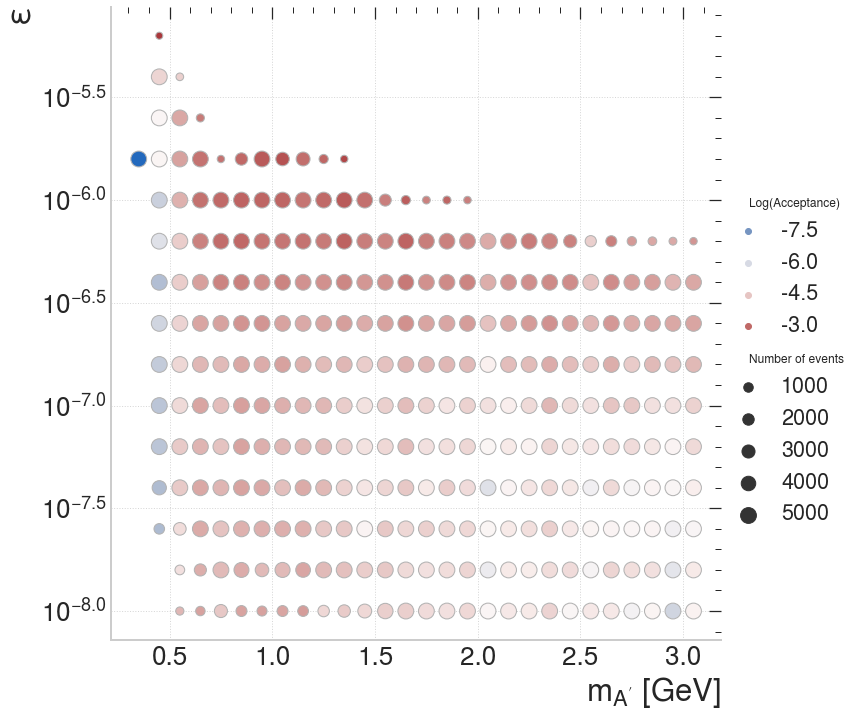

In [76]:
def log_inf(i):
    return None if i == 0 else np.log(i) 

def plot_acceptance(mass, coupling, Nevent, acceptance):
    
    #Create the pandas data frame
    df = pd.DataFrame(data = {"mass": mass,
                        "coupling": coupling,
                        "Number of events":Nevent,
                        "Log(Acceptance)": [log_inf(i) for i in acceptance]})
    
    df = df.sort_values(['mass', 'coupling'])
    
    g = sns.relplot(data=df,
                x="mass", y="coupling", hue="Log(Acceptance)", size="Number of events",
                palette="vlag",
                #hue_norm=(0, 2),
                edgecolor=".7",
                height=10,
                sizes=(50, 250),
                size_norm=(0, 5000),)
    
    # iterate over axes of FacetGrid
    for ax in g.axes.flat:
        labels = ax.get_yticklabels() # get y labels
        
        new_labels = []
        for i,l in enumerate(labels):
            print(labels[i].get_text())
            new_labels.append(r"$10^{%s}$"%labels[i].get_text())

        g.set(yticklabels = new_labels) # set new labels
    
    #Re-label the y axis
    g.set(xlabel=r"$m_{A'}$ [GeV]", ylabel=r"$\epsilon$", aspect="equal")
    
    
plot_acceptance(mass, coupling, Nevent, acceptance)

-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0


/data/t3home000/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


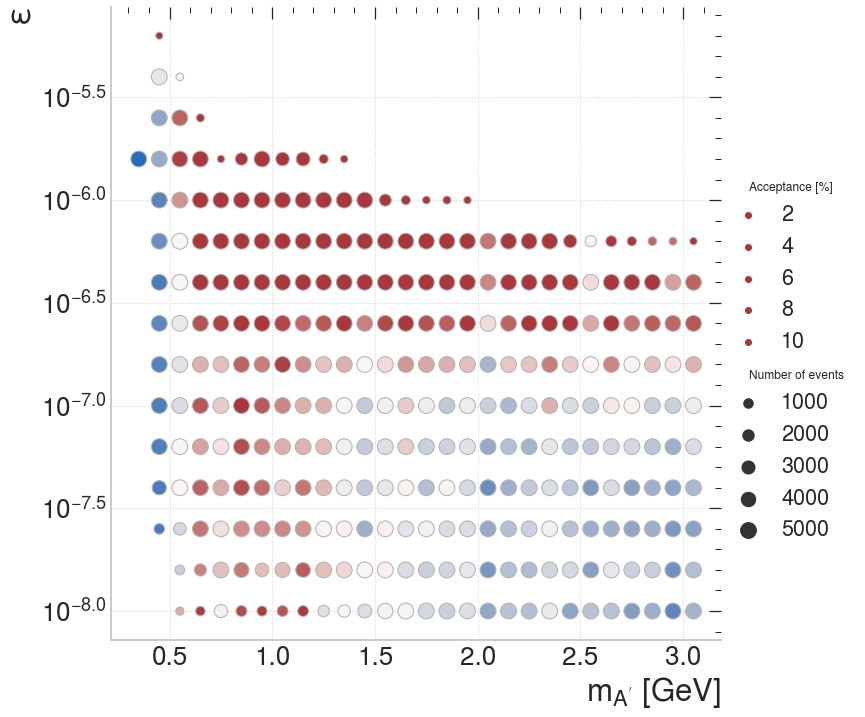

In [83]:
def remove_zero(i):
    return None if i == 0 else i*100

def plot_acceptance(mass, coupling, Nevent, acceptance):
    
    #Create the pandas data frame
    df = pd.DataFrame(data = {"mass": mass,
                        "coupling": coupling,
                        "Number of events":Nevent,
                        "Acceptance [%]": [remove_zero(i) for i in acceptance]})
    
    df = df.sort_values(['mass', 'coupling'])
    
    g = sns.relplot(data=df,
                x="mass", y="coupling", hue="Acceptance [%]", size="Number of events",
                palette="vlag",
                hue_norm=(0, 2),
                edgecolor=".7",
                height=10,
                sizes=(50, 250),
                size_norm=(0, 5000),)
    
    # iterate over axes of FacetGrid
    for ax in g.axes.flat:
        labels = ax.get_yticklabels() # get y labels
        
        new_labels = []
        for i,l in enumerate(labels):
            print(labels[i].get_text())
            new_labels.append(r"$10^{%s}$"%labels[i].get_text())

        g.set(yticklabels = new_labels) # set new labels
    
    #Re-label the y axis
    g.set(xlabel=r"$m_{A'}$ [GeV]", ylabel=r"$\epsilon$", aspect="equal")
    
    
plot_acceptance(mass, coupling, Nevent, acceptance)